In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import folium
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso


import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read the CSV file
df = pd.read_csv('Roma_weather.csv', parse_dates=['DATE'])

In [4]:
df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DP01,DP10,DT32,DX32,DX90,PRCP,TAVG,TMAX,TMIN
0,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,1951-01-01,12.0,7.0,0.0,0.0,0.0,87.1,9.7,13.6,5.8
1,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,1951-02-01,15.0,3.0,0.0,0.0,0.0,27.4,10.5,14.2,6.7
2,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,1951-03-01,12.0,5.0,4.0,0.0,0.0,43.5,10.6,15.4,5.9
3,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,1951-04-01,7.0,3.0,0.0,0.0,0.0,27.1,13.6,18.9,8.2
4,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,1951-05-01,9.0,5.0,0.0,0.0,0.0,40.7,16.6,21.6,11.6


In [5]:
# Data Preprocessing
numeric_columns = ['PRCP', 'TAVG', 'TMAX', 'TMIN']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
# Basic Statistical Analysis
print(df[numeric_columns].describe())

             PRCP        TAVG        TMAX        TMIN
count  770.000000  623.000000  689.000000  703.000000
mean    63.624935   15.569181   21.275907   10.225462
std     52.281702    6.122862    6.845409    5.607757
min      0.000000    3.500000    8.100000   -1.100000
25%     23.150000   10.150000   15.000000    5.500000
50%     53.450000   15.300000   21.200000    9.500000
75%     90.525000   21.200000   27.700000   15.400000
max    266.800000   27.200000   34.400000   21.600000


In [7]:
# Time Series Analysis
df.set_index('DATE', inplace=True)
df.sort_index(inplace=True)

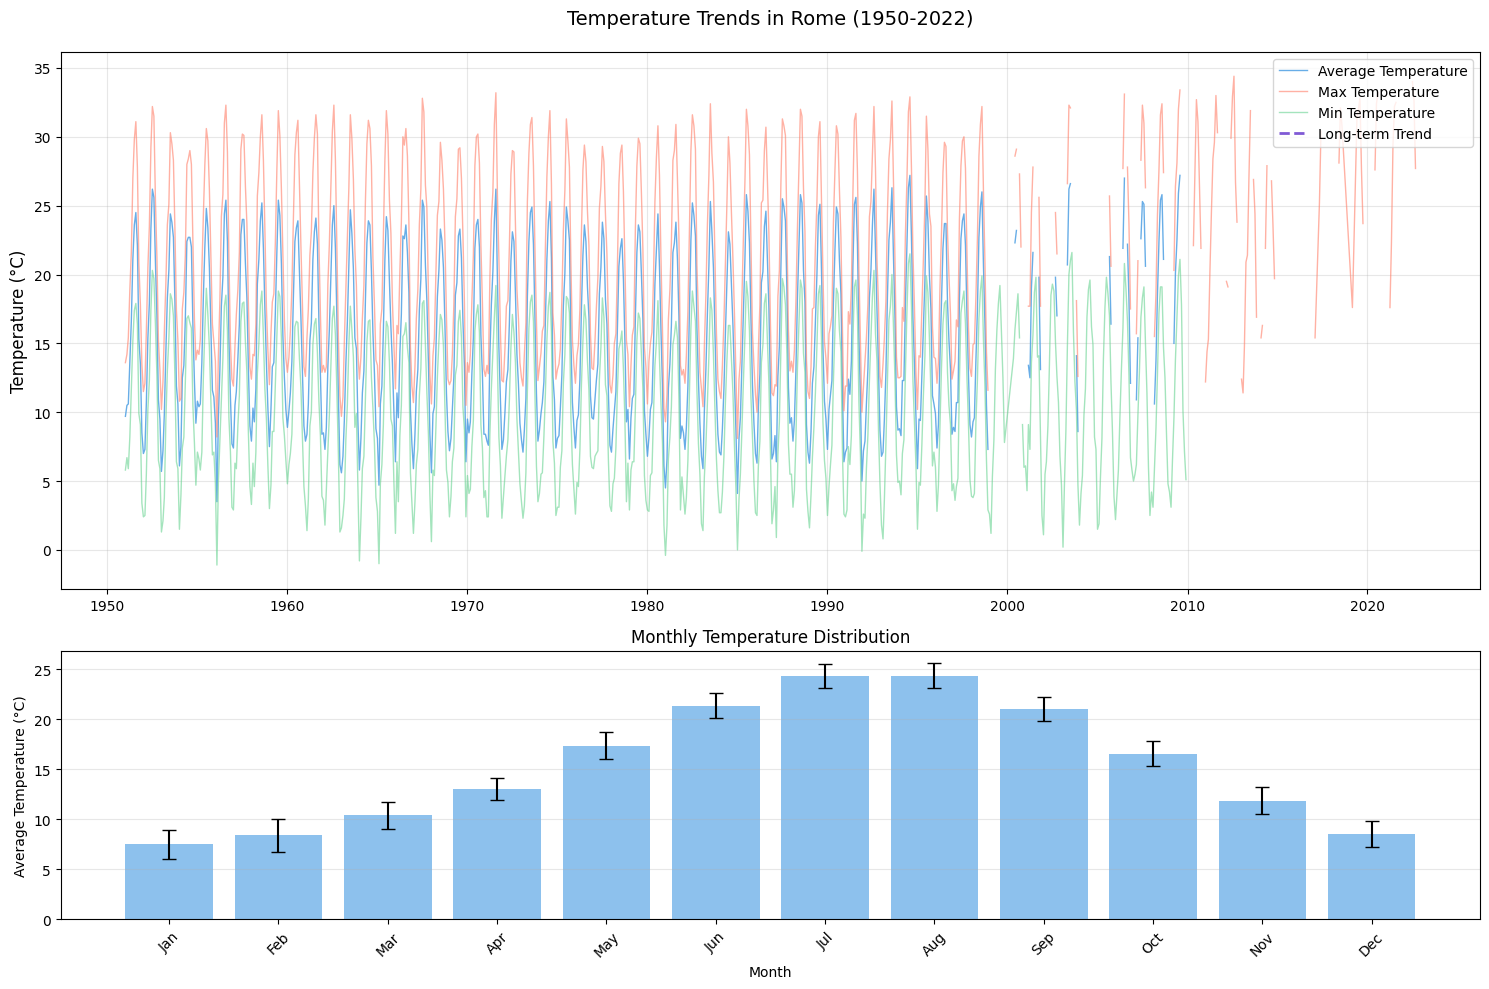

In [8]:
# Set style to a default matplotlib style
plt.style.use('default')  # or try 'classic'

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])

# Plot 1: Temperature trends
ax1.plot(df.index, df['TAVG'], label='Average Temperature', color='#4299e1', alpha=0.8, linewidth=1)
ax1.plot(df.index, df['TMAX'], label='Max Temperature', color='#ff7e67', alpha=0.6, linewidth=1)
ax1.plot(df.index, df['TMIN'], label='Min Temperature', color='#68d391', alpha=0.6, linewidth=1)

# Add trend line
z = np.polyfit(range(len(df.index)), df['TAVG'], 1)
p = np.poly1d(z)
ax1.plot(df.index, p(range(len(df.index))), '--', color='#805ad5', 
         label='Long-term Trend', linewidth=2)

# Customize first plot
ax1.set_title('Temperature Trends in Rome (1950-2022)', pad=20, fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Monthly distribution
monthly_avg = df.groupby(df.index.month)['TAVG'].mean()
monthly_std = df.groupby(df.index.month)['TAVG'].std()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Bar plot with error bars
ax2.bar(range(1, 13), monthly_avg, yerr=monthly_std, 
        color='#4299e1', alpha=0.6, capsize=5)
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months, rotation=45)
ax2.set_title('Monthly Temperature Distribution', fontsize=12)
ax2.set_xlabel('Month', fontsize=10)
ax2.set_ylabel('Average Temperature (°C)', fontsize=10)
ax2.grid(True, axis='y', alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.savefig('Temperature Trends.png')
plt.show()


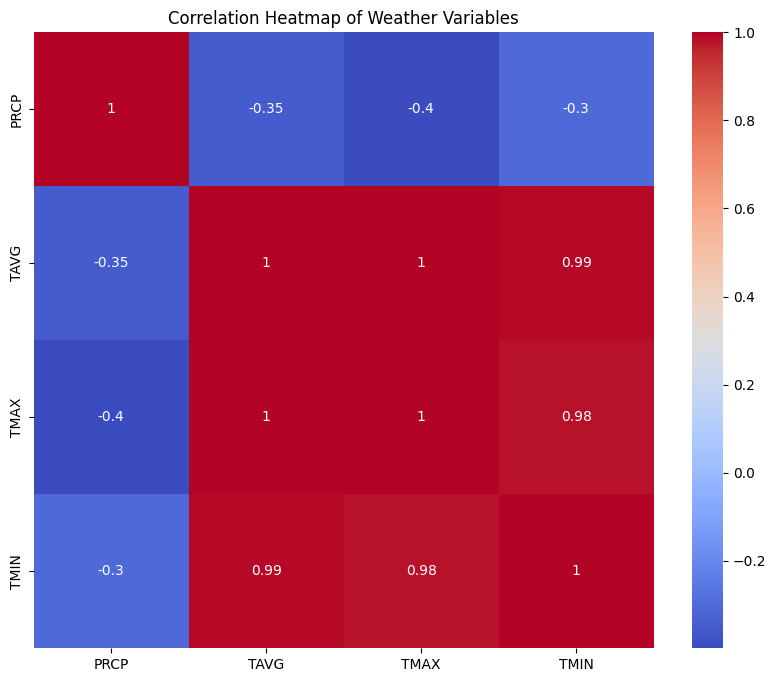

In [9]:
# Correlation Analysis
correlation = df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Weather Variables')
plt.savefig('correlation_heatmap.png')

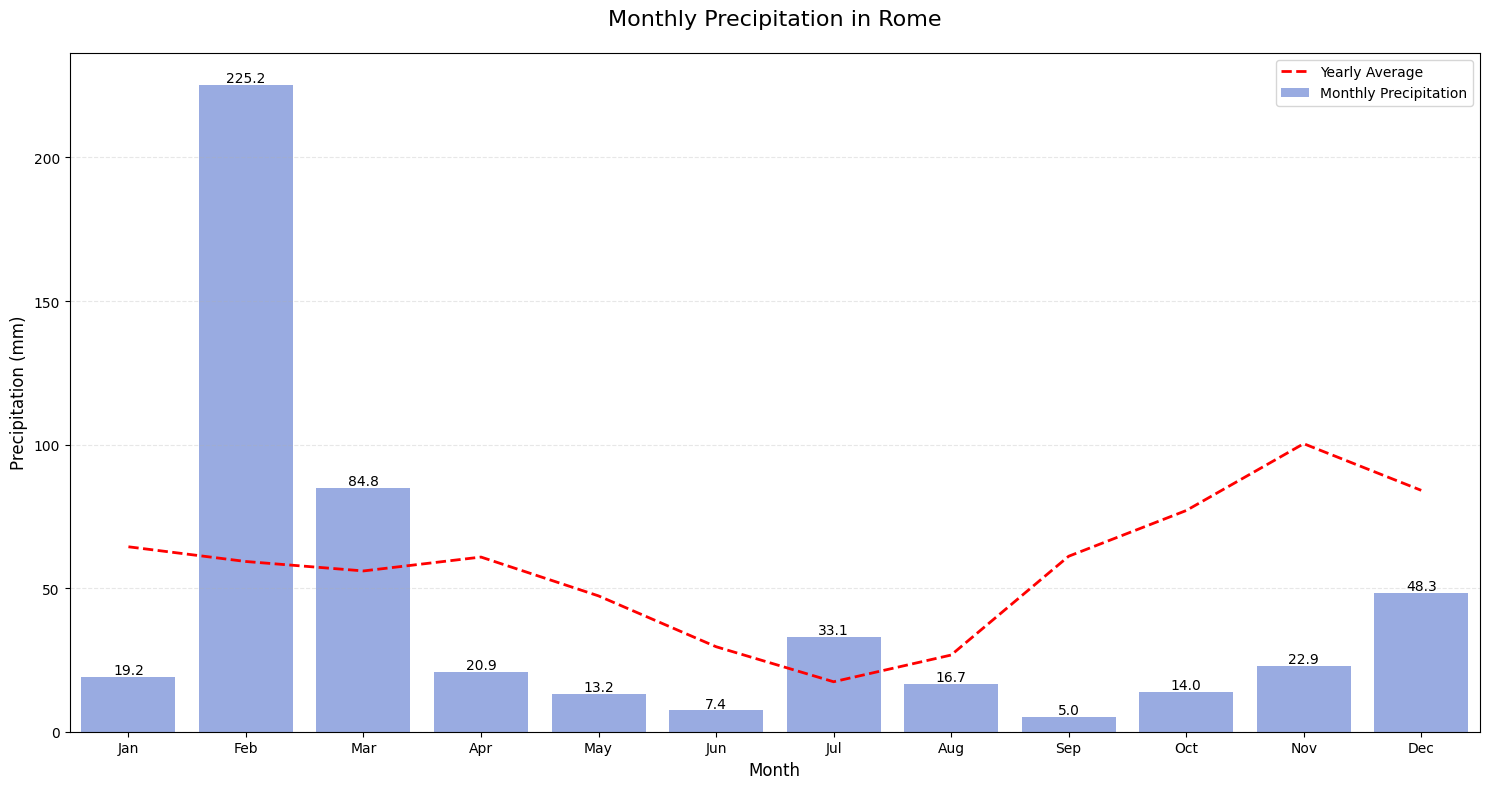

In [10]:
# Precipitation Analysis
plt.figure(figsize=(15, 8))

monthly_precipitation = df['PRCP'].resample('ME').sum()

# Calculate yearly average for comparison
yearly_avg = monthly_precipitation.groupby(monthly_precipitation.index.month).mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
plt.plot(months, yearly_avg.values, 'r--', label='Yearly Average', linewidth=2)
sns.barplot(x=months, 
           y=monthly_precipitation.iloc[-12:].values,  # Last 12 months
           alpha=0.6,
           color='royalblue',
           label='Monthly Precipitation')

# Styling
plt.title('Monthly Precipitation in Rome', pad=20, fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Precipitation (mm)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels only for the bars
for i, v in enumerate(monthly_precipitation.iloc[-12:].values):
    plt.text(i, v + 1, f'{v:.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('monthly_precipitation.png')
plt.show()

In [11]:
df['TAVG']

DATE
1951-01-01     9.7
1951-02-01    10.5
1951-03-01    10.6
1951-04-01    13.6
1951-05-01    16.6
              ... 
2022-05-01     NaN
2022-06-01     NaN
2022-07-01     NaN
2022-08-01     NaN
2022-09-01     NaN
Name: TAVG, Length: 804, dtype: float64

In [12]:
df['TAVG'] = df['TAVG'].interpolate(method='linear')

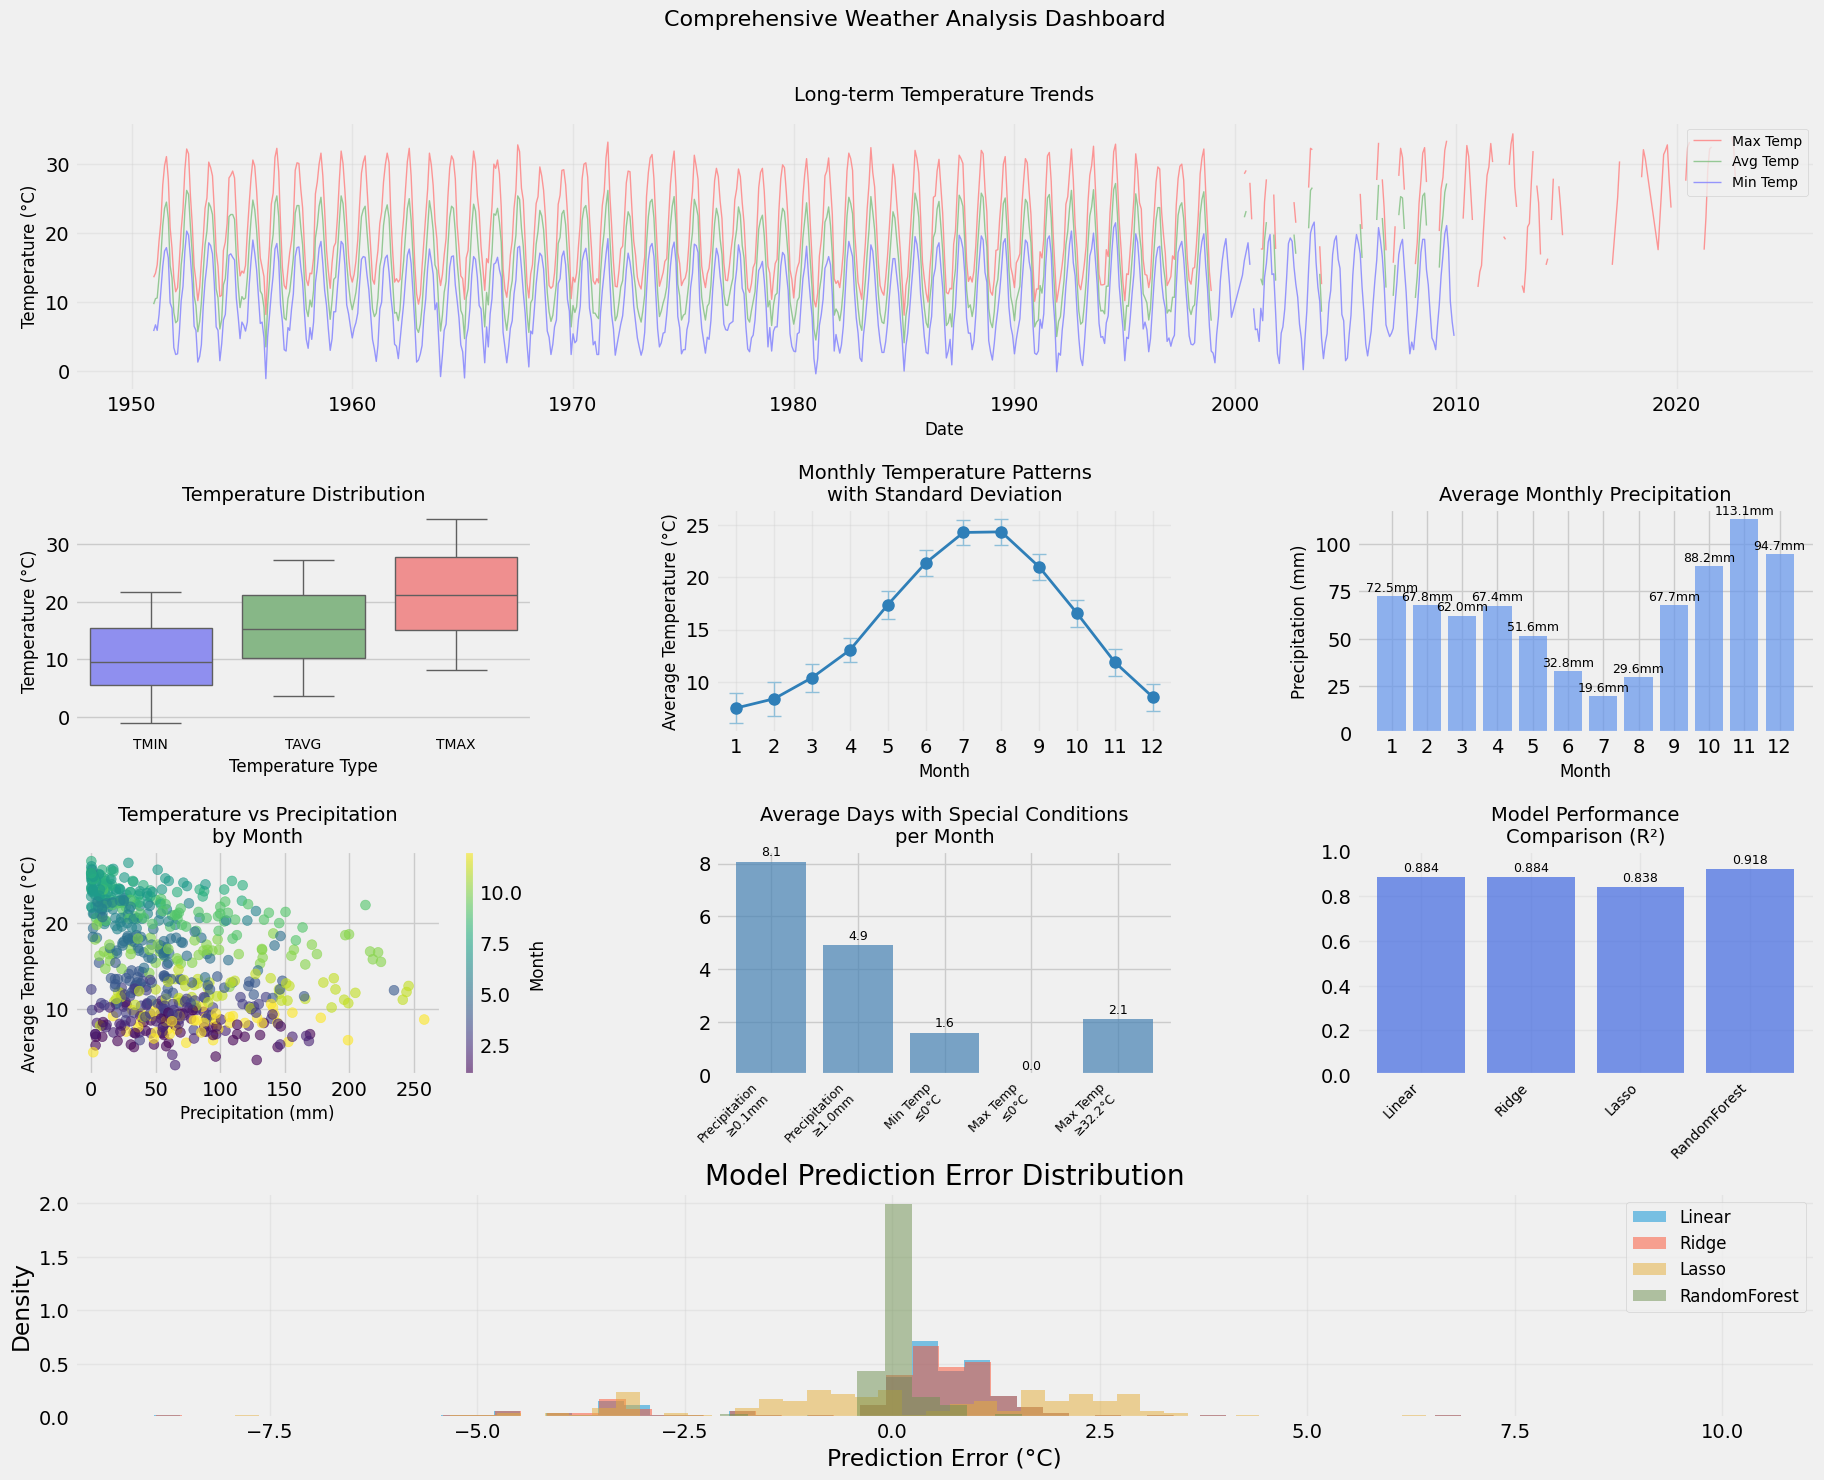

In [13]:
def create_improved_dashboard(df, model_results=None, predictions=None, y_test=None):
    """Create an improved comprehensive dashboard with better visualization"""
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Comprehensive Weather Analysis Dashboard', fontsize=16, y=0.95)
    
    # Define grid layout
    gs = plt.GridSpec(4, 3, height_ratios=[1.2, 1, 1, 1], hspace=0.5, wspace=0.4)
    
    # 1. Temperature Trends with visibility
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df['DATE'], df['TMAX'], label='Max Temp', color='#ff7f7f', alpha=0.8, linewidth=1)
    ax1.plot(df['DATE'], df['TAVG'], label='Avg Temp', color='#7fbf7f', alpha=0.8, linewidth=1)
    ax1.plot(df['DATE'], df['TMIN'], label='Min Temp', color='#7f7fff', alpha=0.8, linewidth=1)
    ax1.set_title('Long-term Temperature Trends', fontsize=14, pad=15)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=10)
    
    # 2. Temperature Distribution with styling
    ax2 = fig.add_subplot(gs[1, 0])
    sns.boxplot(data=df[['TMIN', 'TAVG', 'TMAX']], ax=ax2, 
                palette=['#7f7fff', '#7fbf7f', '#ff7f7f'])
    ax2.set_title('Temperature Distribution', fontsize=14)
    ax2.set_xlabel('Temperature Type', fontsize=12)
    ax2.set_ylabel('Temperature (°C)', fontsize=12)
    ax2.tick_params(axis='x', rotation=0)
    ax2.set_xticklabels(['TMIN', 'TAVG', 'TMAX'], fontsize=10)
    
    # 3. Monthly Temperature Patterns with error bars
    ax3 = fig.add_subplot(gs[1, 1])
    monthly_stats = df.groupby(df['DATE'].dt.month)['TAVG'].agg(['mean', 'std']).reset_index()
    ax3.errorbar(monthly_stats['DATE'], monthly_stats['mean'], 
                yerr=monthly_stats['std'], fmt='o-', capsize=5,
                color='#2f7fb8', ecolor='#8fbfd9', markersize=8, 
                linewidth=2, elinewidth=1, capthick=1)
    ax3.set_title('Monthly Temperature Patterns\nwith Standard Deviation', fontsize=14)
    ax3.set_xlabel('Month', fontsize=12)
    ax3.set_ylabel('Average Temperature (°C)', fontsize=12)
    ax3.set_xticks(range(1, 13))
    ax3.grid(True, alpha=0.3)
    
    # 4. Monthly Precipitation with styling
    ax4 = fig.add_subplot(gs[1, 2])
    monthly_precip = df.groupby(df['DATE'].dt.month)['PRCP'].mean()
    bars = ax4.bar(range(1, 13), monthly_precip.values, 
                  color='#6495ed', alpha=0.7)
    ax4.set_title('Average Monthly Precipitation', fontsize=14)
    ax4.set_xlabel('Month', fontsize=12)
    ax4.set_ylabel('Precipitation (mm)', fontsize=12)
    ax4.set_xticks(range(1, 13))
    
    # Bar labels
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}mm',
                ha='center', va='bottom', fontsize=9)
    
    # 5. Temperature vs Precipitation scatter
    ax5 = fig.add_subplot(gs[2, 0])
    scatter = ax5.scatter(df['PRCP'], df['TAVG'], 
                         c=df['DATE'].dt.month, cmap='viridis', 
                         alpha=0.6, s=50)
    ax5.set_title('Temperature vs Precipitation\nby Month', fontsize=14)
    ax5.set_xlabel('Precipitation (mm)', fontsize=12)
    ax5.set_ylabel('Average Temperature (°C)', fontsize=12)
    colorbar = plt.colorbar(scatter, ax=ax5)
    colorbar.set_label('Month', fontsize=12)
    
    # 6. Special Conditions with formatting
    ax6 = fig.add_subplot(gs[2, 1])
    conditions = ['DP01', 'DP10', 'DT32', 'DX32', 'DX90']
    condition_means = [df[cond].mean() for cond in conditions]
    condition_labels = ['Precipitation\n≥0.1mm', 'Precipitation\n≥1.0mm', 
                       'Min Temp\n≤0°C', 'Max Temp\n≤0°C', 'Max Temp\n≥32.2°C']
    bars = ax6.bar(range(len(conditions)), condition_means, 
                   color='#4682b4', alpha=0.7)
    ax6.set_title('Average Days with Special Conditions\nper Month', fontsize=14)
    ax6.set_xticks(range(len(conditions)))
    ax6.set_xticklabels(condition_labels, rotation=45, ha='right', fontsize=9)
    
    # Bar labels
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)
    
    # 7. Model Performance with styling
    if model_results is not None:
        ax7 = fig.add_subplot(gs[2, 2])
        models = list(model_results.keys())
        r2_scores = [score['r2'] for score in model_results.values()]
        bars = ax7.bar(models, r2_scores, color='#4169e1', alpha=0.7)
        ax7.set_title('Model Performance\nComparison (R²)', fontsize=14)
        ax7.set_ylim(0, 1)
        ax7.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
        ax7.grid(True, alpha=0.3)
        
        # Enhanced bar labels
        for bar in bars:
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)
            
    # 8. Prediction Error Distribution
    if predictions is not None and y_test is not None:
        ax8 = fig.add_subplot(gs[3, :])
        for model_name, preds in predictions.items():
            errors = y_test - preds
            ax8.hist(errors, bins=50, alpha=0.5, label=model_name, density=True)
        ax8.set_title('Model Prediction Error Distribution')
        ax8.set_xlabel('Prediction Error (°C)')
        ax8.set_ylabel('Density')
        ax8.legend(fontsize=12)
        ax8.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def run_comprehensive_analysis(df):
    """Run complete analysis pipeline"""
    # Prepare features
    df['Temp_Range'] = df['TMAX'] - df['TMIN']
    df['Temp_7day_avg'] = df['TAVG'].rolling(window=7).mean()
    df['Precip_Temp_Interaction'] = df['PRCP'] * df['TAVG']
    
    # Model training and evaluation
    feature_cols = ['PRCP', 'TMIN', 'TMAX', 'Temp_Range',
                   'Temp_7day_avg', 'Precip_Temp_Interaction']
    X = df[feature_cols].copy()
    y = df['TAVG'].interpolate(method='linear')
    
    X = X.fillna(X.mean())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    # Train models
    models = {
        'Linear': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    predictions = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = {
            'r2': model.score(X_test, y_test)
        }
        predictions[name] = y_pred
    
    return results, predictions, create_improved_dashboard(df, results, predictions, y_test)

df = pd.read_csv('Roma_weather.csv', parse_dates=['DATE'])
results, predictions, fig = run_comprehensive_analysis(df)
plt.show()  
fig.savefig('comprehensive_weather_analysis.png', dpi=300, bbox_inches='tight')

In [4]:
import importlib

libraries = [
    "streamlit",
    "pandas",
    "plotly",
    "numpy",
    "scipy",
    "scikit-learn",
    "pymannkendall",
    "statsmodels",
    "folium",
    "seaborn",
]

for lib in libraries:
    try:
        # Dynamically import the library
        module = importlib.import_module(lib)
        # Retrieve and print the version
        print(f"{lib}: {module.__version__}")
    except ImportError:
        print(f"{lib}: Not installed")
    except AttributeError:
        print(f"{lib}: Version information not available")

streamlit: 1.40.1
pandas: 2.2.3
plotly: 5.18.0
numpy: 2.1.2
scipy: 1.14.1
scikit-learn: Not installed
pymannkendall: 1.4.3
statsmodels: 0.14.4
folium: 0.18.0
seaborn: 0.13.2
